In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
taxonomy = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/taxonomy_engagement_data.csv')
taxonomy.columns

Index(['id', 'user_id', 'content_id', 'engagement_metadata', 'media_type',
       's3_url', 'is_like', 'is_dislike', 'msEngagement', 'seed',
       'num_inference_steps', 'guidance_scale', 'prompt', 'original_prompt',
       'artist_style', 'source', 'generated_type', 'model', 'model_version',
       'text'],
      dtype='object')

In [ ]:
content = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/content.csv') # 180,508 non-duplicated rows
content.columns

Index(['content_id', 'media_type', 's3_url', 'seed', 'num_inference_steps',
       'guidance_scale', 'prompt', 'original_prompt', 'artist_style', 'source',
       'generated_type', 'model', 'model_version', 'text'],
      dtype='object')

In [ ]:
def calculate_interaction(df):
    """
    Args:
        df: DataFrame containing content_id, msEngagement, is_like, and is_dislike columns
    """
    df.fillna({'msEngagement': 0}, inplace=True)
    data_clean = df.groupby(['user_id','content_id']).agg({'media_type': 'first', 'prompt': 'first', 's3_url': 'first',
                                                 'msEngagement': 'mean', 'is_like': 'mean', 'is_dislike': 'mean'}).reset_index()
    scaler = MinMaxScaler()
    data_clean['msEngagement'] = scaler.fit_transform(data_clean[['msEngagement']])
    data_clean['interaction'] = (data_clean['is_like'] - data_clean['is_dislike']) * 1.5 + data_clean['msEngagement'] # weigh likes a little bit more than engagement
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_clean['interaction'] = scaler.fit_transform(data_clean[['interaction']])

    return data_clean

In [ ]:
taxonomy = calculate_interaction(taxonomy)

## BERT embeddings

In [ ]:
def preprocess_text(text, stopwords, stem, lemma):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    token = text.split()
    token = [word for word in token if word not in stopwords]
    if stem == True:
        ps = nltk.stem.porter.PorterStemmer()
        token = [ps.stem(word) for word in token]
    if lemma == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        token = [lem.lemmatize(word) for word in token]
    text = " ".join(token)
    return text

In [ ]:
def generate_embeddings(df):
    """
    Returns a list of BERT embeddings for each prompt in the DataFrame
    """
    stop_words = stopwords.words("english")

    df.loc[:, 'prompt_clean'] = df['prompt'].apply(lambda x: preprocess_text(x, stop_words, True, True))
    df_prompts = df['prompt_clean'].dropna().tolist()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased').to(device)
    svd = TruncatedSVD(n_components=128)
    scaler = StandardScaler()

    def get_embeddings(text):
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
        outputs = model(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().detach().numpy()
        return embeddings

    embeddings = [get_embeddings(prompt) for prompt in df_prompts]
    embeddings = np.array([embedding[0] for embedding in embeddings])
    embeddings_df = pd.DataFrame(embeddings).reset_index(drop=True)
    media_type_dummies = pd.get_dummies(df['media_type'], prefix='media_type')
    media_type_dummies = media_type_dummies.astype(int).reset_index(drop=True)
    prompt_media_embeddings = pd.concat([embeddings_df, media_type_dummies], axis=1)
    prompt_media_embeddings.columns = prompt_media_embeddings.columns.astype(str)
    standardized_features = scaler.fit_transform(prompt_media_embeddings)
    reduced_embeddings = svd.fit_transform(standardized_features)

    return reduced_embeddings

In [ ]:
# prompt_media_embeddings = generate_embeddings(content)
# np.save('/content/drive/MyDrive/Colab Notebooks/full_content_embeddings.npy', np.array(prompt_media_embeddings))

In [ ]:
prompt_media_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/full_content_embeddings.npy')
print(prompt_media_embeddings.shape)
content['embeddings'] = prompt_media_embeddings.tolist()

(180508, 128)


# Clustering

In [ ]:
# n_components=128
# pca = PCA(n_components=n_components)
# pca_features = pca.fit_transform(prompt_media_embeddings)
# pca_df = pd.DataFrame(pca_features, columns=[f'PCA_{i}' for i in range(n_components)])

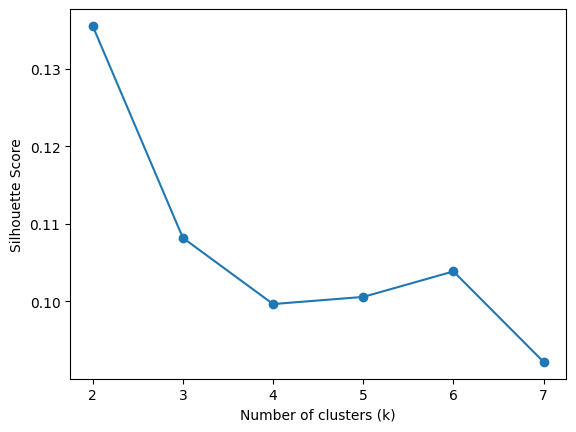

In [ ]:
silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 'auto')
    labels = kmeans.fit_predict(prompt_media_embeddings)
    silhouette_avg = silhouette_score(prompt_media_embeddings, labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2,8), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(prompt_media_embeddings)
content['cluster'] = kmeans.labels_
content['cluster'].value_counts()

,count
cluster,
1,58155
5,32500
0,28851
3,22991
4,21452
2,16559


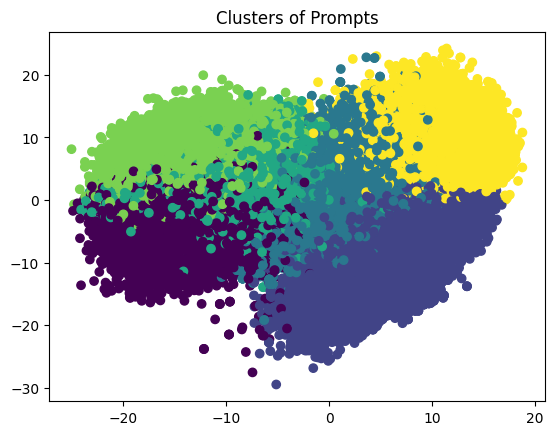

In [ ]:
plt.scatter(prompt_media_embeddings[:, 0], prompt_media_embeddings[:, 1], c=kmeans.labels_)
plt.title("Clusters of Prompts")
plt.show()

In [ ]:
from IPython.display import display, Image, clear_output

test = content[content['cluster'] == 4]
def display_content(content_id):
    """Displays a single content piece."""
    pd.set_option('display.max_colwidth', None)
    content_displayed = content[content['content_id'] == content_id].iloc[0,:-2]

    display(pd.DataFrame(content_displayed).T)
    if content_displayed['media_type']=='Image':
        display(Image(url=content_displayed['s3_url'], width=300, height=300))
# for i in range(10):
#     display_content(test.iloc[i,0])

# Online Candidate Generator

In [ ]:
def get_content(user_data, user_id, number_of_content, full_content, offset=0):
    user_data = user_data[user_data['user_id'] == user_id]
    if user_data.empty:
        return

    # user_data = calculate_interaction(user_data) # use this if used real-time online, in order to calculate interaction
    # get contents that are liked by the user
    high_interaction_content = user_data[user_data['interaction'] > 0.49]

    if not high_interaction_content.empty:
        # if user engages with data that is not included in content.csv
        # user_embeddings = generate_embeddings(high_interaction_content)
        # embeddings of all positive interacted content
        user_embeddings = full_content[full_content['content_id'].isin(high_interaction_content['content_id'].explode().unique())]['embeddings'].tolist()
        highest_interaction_content = high_interaction_content.sort_values(by='interaction', ascending=False).loc[0, 'content_id']
        cluster_label = full_content.loc[full_content['content_id'] == highest_interaction_content, 'cluster'].values[0]
    else:
        return

    # find similar content in the same cluster with the one mostly liked by the user
    cluster_data = full_content[full_content['cluster']==cluster_label]
    # similarity between positive interacted content and all the cluster data
    similarity_scores = cosine_similarity(user_embeddings, cluster_data['embeddings'].tolist())
    similarity_scores = np.mean(similarity_scores, axis=0)
    sorted_indices = np.argsort(similarity_scores)[::-1]
    sorted_content_ids = [cluster_data.iloc[i]['content_id'] for i in sorted_indices]

    existing_content = user_data['content_id'].tolist()
    sorted_content_ids = [item for item in sorted_content_ids if item not in existing_content]

    return sorted_content_ids[offset:offset + number_of_content]

In [ ]:
rec = get_content(taxonomy, '00328ce57bbc14b33bd6695bc8eb32cdf2fb5f3a7d89ec14a42825e15d39df60', 20, content, 0)

[39603, 58592, 55603, 72379, 68075, 107351, 58659, 72482, 45710, 35779, 74690, 74223, 55179, 49006, 38130, 36252, 67346, 69518, 39632, 63268, 34693, 37062, 46551, 33516, 55648, 78332, 79480, 77563, 72401, 94770, 35187, 36186, 69298, 73014, 33583, 39610, 42838, 75014, 66082, 65168, 50559, 37517, 33600, 77121, 72385, 66857, 51323, 56460, 102326, 46545, 41368, 71544, 57567, 73028, 47405, 50746, 33877, 74249, 33894, 75192, 77519, 63245, 31077, 36292, 53114, 40451, 29176, 47965, 59762, 64404, 36979, 51449, 60209, 40237, 77273, 51459, 37849, 77464, 68201, 65826, 75993, 65155, 38955, 94342, 45268, 49420, 35798, 57526, 39961, 45931, 67302, 40545, 67219, 76998, 55987, 69014, 71543, 38408, 55810, 46897, 48993, 36794, 47925, 36718, 65174, 41954, 67239, 55362, 35296, 44507, 61057, 55154, 75197, 69357, 31424, 75083, 48967, 62186, 50640, 62290, 60443, 78409, 40636, 47096, 44930, 60906, 35607, 44292, 48366, 66954, 47448, 44025, 37053, 101637, 65166, 36118, 46024, 72668, 72169, 37888, 39654, 48991, 63

In [ ]:
for i in rec:
    display_content(i)

,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
161604,39603,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Prometheus/75/11/8/11235.png,11.0,75.0,8.0,"A second excavator glides out of the dark. At the controls: PROFESSOR MARTIN HOLLOWAY, 48, visionary genius and archaeologist. Dark-haired and lean, with the rangy build of a frontiersman. He's dressed in work trousers and a T-shirt. Stubbly chin. He plays his floodlights over the obelisk.\\n. In the style of the movie Prometheus. dim volumetric cinematic lighting, 8k","A second excavator glides out of the dark. At the controls: PROFESSOR MARTIN HOLLOWAY, 48, visionary genius and archaeologist. Dark-haired and lean, with the rangy build of a frontiersman. He's dressed in work trousers and a T-shirt. Stubbly chin. He plays his floodlights over the obelisk.\\n",movie: Prometheus,Prometheus,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
118722,58592,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Avengers-Endgame/75/10/4/30664.png,10.0,75.0,4.0,"THE MOON HANGS HUGE OVER THE EARTH. Then the silhouette of THE BENATAR races past, propelled by CAROL DANVERS. Below...STEVE ROGERS, BRUCE BANNER, AND NATASHA ROMANOV watch a flying woman guide the ship to the ground. Behind them, PEPPER POTTS walks up to the group. Steve races up as NEBULA helps Tony down the ramp.\\n. In the style of the movie Avengers-Endgame. dim volumetric cinematic lighting, 8k","THE MOON HANGS HUGE OVER THE EARTH. Then the silhouette of THE BENATAR races past, propelled by CAROL DANVERS. Below...STEVE ROGERS, BRUCE BANNER, AND NATASHA ROMANOV watch a flying woman guide the ship to the ground. Behind them, PEPPER POTTS walks up to the group. Steve races up as NEBULA helps Tony down the ramp.\\n",movie: Avengers-Endgame,Avengers-Endgame,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
147954,55603,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Schindlers-List/75/14/7.5/27606.png,14.0,75.0,8.0,"Tables and tools and enamelware scrap. The metal presses and lathes, still. The firing ovens, cold. The gauges at zero. Against the wall of windows overlooking the empty factory floor stands a figure, Schindler, in silhouette against the glass, black against white, not moving, just staring down.\\n. In the style of the movie Schindlers-List. dim volumetric cinematic lighting, 8k","Tables and tools and enamelware scrap. The metal presses and lathes, still. The firing ovens, cold. The gauges at zero. Against the wall of windows overlooking the empty factory floor stands a figure, Schindler, in silhouette against the glass, black against white, not moving, just staring down.\\n",movie: Schindlers-List,Schindlers-List,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
71501,72379,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Jurassic-Park-III/75/13/8/44734.png,13.0,75.0,8.0,"The jungle has almost reclaimed this patchy vine-covered runway. The airplane is parked at one end. Nash, Udesky, and Cooper are checking their weapons. Amanda is at the edge of the tarmac calling into the jungle on a BULLHORN. Billy and a groggy Grant emerge from the airplane. Paul trots over.\\n. In the style of the movie Jurassic-Park-III. dim volumetric cinematic lighting, 8k","The jungle has almost reclaimed this patchy vine-covered runway. The airplane is parked at one end. Nash, Udesky, and Cooper are checking their weapons. Amanda is at the edge of the tarmac calling into the jungle on a BULLHORN. Billy and a groggy Grant emerge from the airplane. Paul trots over.\\n",movie: Jurassic-Park-III,Jurassic-Park-III,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
129846,68075,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Hudsucker-Proxy-The/75/12/8.5/40331.png,12.0,75.0,8.0,"NEWSREEL A scientist with a Van Dyke beard, wearing a laboratory smock, is facing the camera. Behind him we see other scientists studying a hoop that has been hooked up to a gyroscopic- looking device that analyzes its various movements and properties.\\n. In the style of the movie Hudsucker-Proxy-The. dim volumetric cinematic lighting, 8k","NEWSREEL A scientist with a Van Dyke beard, wearing a laboratory smock, is facing the camera. Behind him we see other scientists studying a hoop that has been hooked up to a gyroscopic- looking device that analyzes its various movements and properties.\\n",movie: Hudsucker-Proxy-The,Hudsucker-Proxy-The,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
139661,107351,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_special_prompts/human_prompts/75/2856817264/9/24181.png,2147483647.0,75.0,9.0,"a very beautiful anime elf girl, full body, long silver hair with a flower, sky blue eyes, full round face, short smile, revealing clothes, thick thigs, firm chest, ice snowy lake setting, cinematic lightning, medium shot, mid-shot, highly detailed, trending on Artstation, Unreal Engine 4k, cinematic wallpaper by Stanley Artgerm Lau, WLOP, Rossdraws, James Jean, Andrei Riabovitchev, Marc Simonetti, and Sakimichan","a very beautiful anime elf girl, full body, long silver hair with a flower, sky blue eyes, full round face, short smile, revealing clothes, thick thigs, firm chest, ice snowy lake setting, cinematic lightning, medium shot, mid-shot, highly detailed, trending on Artstation, Unreal Engine 4k, cinematic wallpaper by Stanley Artgerm Lau, WLOP, Rossdraws, James Jean, Andrei Riabovitchev, Marc Simonetti, and Sakimichan",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
151017,58659,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Schindlers-List/75/11/9/30732.png,11.0,75.0,9.0,"Workers glance up at a horrible apparition from the pit of their foulest dreams -- Amon Goeth crossing through the factory. Schindler, his arm around the killer's shoulder as if he were a long lost brother, leads him across the shop-floor, proudly pointing out to him the huge thundering Hilo machines.\\n. In the style of the movie Schindlers-List. dim volumetric cinematic lighting, 8k","Workers glance up at a horrible apparition from the pit of their foulest dreams -- Amon Goeth crossing through the factory. Schindler, his arm around the killer's shoulder as if he were a long lost brother, leads him across the shop-floor, proudly pointing out to him the huge thundering Hilo machines.\\n",movie: Schindlers-List,Schindlers-List,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
58668,72482,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Tremors/75/8/7.5/44840.png,8.0,75.0,8.0,"The pick-up rattles toward a tiny, utterly isolated high desert hamlet -- a few dozen houses and mobile homes fighting for shade in the vast landscape. Its most prominent feature is an aging wood-frame water tower, perhaps 25 feet high, near the center of town. A sign PANS into view -- ""PERFECTION -- Pop. 14.""\\n. In the style of the movie Tremors. dim volumetric cinematic lighting, 8k","The pick-up rattles toward a tiny, utterly isolated high desert hamlet -- a few dozen houses and mobile homes fighting for shade in the vast landscape. Its most prominent feature is an aging wood-frame water tower, perhaps 25 feet high, near the center of town. A sign PANS into view -- ""PERFECTION -- Pop. 14.""\\n",movie: Tremors,Tremors,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
145504,45710,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Rush/75/9/7/17477.png,9.0,75.0,7.0,"A large boardroom. Team Director TEDDY MAYER American, from Pennsylvania, short, lawyerly, 50's - hair turning grey sits at the head of the table. Next to him is Aussie Marlboro spokesman JOHN HOGAN and McLaren Team Manager and chief mechanic ALASTAIR CALDWELL. The atmosphere is tense, uncomfortable...\\n. In the style of the movie Rush. dim volumetric cinematic lighting, 8k","A large boardroom. Team Director TEDDY MAYER American, from Pennsylvania, short, lawyerly, 50's - hair turning grey sits at the head of the table. Next to him is Aussie Marlboro spokesman JOHN HOGAN and McLaren Team Manager and chief mechanic ALASTAIR CALDWELL. The atmosphere is tense, uncomfortable...\\n",movie: Rush,Rush,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
78687,35779,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/BlacKkKlansman/75/14/7/7336.png,14.0,75.0,7.0,"DRONE SHOT Superimposed: Early 70s An amazing contrast. The beautiful landscape of Colorado Springs, the City sits nestled within the rugged Mountain terrain. The majestic Pikes Peak, the jagged beauty of The Garden of the Gods, The plush Broadmoor Resort, The Will Rodgers Shrine of The Sun.\\n. In the style of the movie BlacKkKlansman. dim volumetric cinematic lighting, 8k","DRONE SHOT Superimposed: Early 70s An amazing contrast. The beautiful landscape of Colorado Springs, the City sits nestled within the rugged Mountain terrain. The majestic Pikes Peak, the jagged beauty of The Garden of the Gods, The plush Broadmoor Resort, The Will Rodgers Shrine of The Sun.\\n",movie: BlacKkKlansman,BlacKkKlansman,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
16012,74690,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Jaws/75/15/10/47110.png,15.0,75.0,10.0,"Martin Brody's Country Squire police wagon rushes past, taking the view to an enormous billboard depicting a typical summer day in Amity. A beautiful model splashes in the gold surf, languishing in a Solarcaine sun. AMITY WELCOMES YOU is written above her flailing arms.\\n. In the style of the movie Jaws. dim volumetric cinematic lighting, 8k","Martin Brody's Country Squire police wagon rushes past, taking the view to an enormous billboard depicting a typical summer day in Amity. A beautiful model splashes in the gold surf, languishing in a Solarcaine sun. AMITY WELCOMES YOU is written above her flailing arms.\\n",movie: Jaws,Jaws,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
36830,74223,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Wild-Wild-West/75/9/8/46632.png,9.0,75.0,8.0,"As he giggles, the distaff corps surround him and remove the Lincoln paraphernalia. Then step aside, revealing... NEW ANGLE - DR. LOVELESS is half a man. Literally. Cut off at the waist and mounted on a wheelchair platform that is powered by an engine, he is a man bereft of tuchus, kishkes and everything else in that vicinity that makes life interesting.\\n. In the style of the movie Wild-Wild-West. dim volumetric cinematic lighting, 8k","As he giggles, the distaff corps surround him and remove the Lincoln paraphernalia. Then step aside, revealing... NEW ANGLE - DR. LOVELESS is half a man. Literally. Cut off at the waist and mounted on a wheelchair platform that is powered by an engine, he is a man bereft of tuchus, kishkes and everything else in that vicinity that makes life interesting.\\n",movie: Wild-Wild-West,Wild-Wild-West,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
169652,55179,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Lone-Star/75/8/9/27171.png,8.0,75.0,9.0,"We WIDEN as the skull is lifted by WESLEY BIRDSONG, a Native American man in his 70s who wears extremely thick glasses. Sam tags along as the old man rearranges the display of Texas curios laid out in front of his trailer. Empty scrubland surrounds them.\\n. In the style of the movie Lone-Star. dim volumetric cinematic lighting, 8k","We WIDEN as the skull is lifted by WESLEY BIRDSONG, a Native American man in his 70s who wears extremely thick glasses. Sam tags along as the old man rearranges the display of Texas curios laid out in front of his trailer. Empty scrubland surrounds them.\\n",movie: Lone-Star,Lone-Star,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
22712,49006,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Star-Wars-A-New-Hope/75/10/4/20863.png,10.0,75.0,4.0,"The Landspeeder with Luke, Artoo, Threepio, and Ben in it zooms across the desert. The speeder stops on a bluff overlooking the spaceport at Mos Eisley. It is a haphazard array of low, grey, concrete structures and semi-domes. A harsh gale blows across the stark canyon floor. Luke adjusts his goggles and walks to the edge of the craggy bluff where Ben is standing.\\n. In the style of the movie Star-Wars-A-New-Hope. dim volumetric cinematic lighting, 8k","The Landspeeder with Luke, Artoo, Threepio, and Ben in it zooms across the desert. The speeder stops on a bluff overlooking the spaceport at Mos Eisley. It is a haphazard array of low, grey, concrete structures and semi-domes. A harsh gale blows across the stark canyon floor. Luke adjusts his goggles and walks to the edge of the craggy bluff where Ben is standing.\\n",movie: Star-Wars-A-New-Hope,Star-Wars-A-New-Hope,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
133785,38130,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Hudson-Hawk/75/8/8.5/9733.png,8.0,75.0,8.0,"An explosion of steam and gas blows out the windows! Debris frisbees toward the camera along with.... Anna, hanging on Hawk's waist, and Hawk, hanging from the bar on DA VINCI'S BAT WINGED GLIDER. The glider gracefully swooshes down through the castle - through the glorious vista.\\n. In the style of the movie Hudson-Hawk. dim volumetric cinematic lighting, 8k","An explosion of steam and gas blows out the windows! Debris frisbees toward the camera along with.... Anna, hanging on Hawk's waist, and Hawk, hanging from the bar on DA VINCI'S BAT WINGED GLIDER. The glider gracefully swooshes down through the castle - through the glorious vista.\\n",movie: Hudson-Hawk,Hudson-Hawk,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
35651,36252,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Rambo-First-Blood-II-The-Mission/75/7/4/7817.png,7.0,75.0,4.0,"Brewer raises the rifle, sighting through the massive starlight scope. BREWER'S POV - TELEPHOTO The image is bright, lurid... black and white with a greenish cast. Like contrasty daylight. He pans up the tower. A Russian-made P.K. 7.62mm machine gun sits pointing skyward. The tower seems unoccupied.\\n. In the style of the movie Rambo-First-Blood-II-The-Mission. dim volumetric cinematic lighting, 8k","Brewer raises the rifle, sighting through the massive starlight scope. BREWER'S POV - TELEPHOTO The image is bright, lurid... black and white with a greenish cast. Like contrasty daylight. He pans up the tower. A Russian-made P.K. 7.62mm machine gun sits pointing skyward. The tower seems unoccupied.\\n",movie: Rambo-First-Blood-II-The-Mission,Rambo-First-Blood-II-The-Mission,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
65835,67346,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Bruce-Almighty/75/15/7.5/39583.png,15.0,75.0,8.0,"A news crew shuttles around a GIGANTIC COOKIE. Standing by are the KOWOLSKI BROTHERS, GUSTOV and VOL, two SHORT, STOCKY, MEN, along with MOTHER KOWOLSKI and other bakery family employees. A ""30 YEAR ANNIVERSARY"" sign hangs in the background. BRUCE NOLAN looks into a make-up mirror, desperately trying to place a large segment of wayward hair.\\n. In the style of the movie Bruce-Almighty. dim volumetric cinematic lighting, 8k","A news crew shuttles around a GIGANTIC COOKIE. Standing by are the KOWOLSKI BROTHERS, GUSTOV and VOL, two SHORT, STOCKY, MEN, along with MOTHER KOWOLSKI and other bakery family employees. A ""30 YEAR ANNIVERSARY"" sign hangs in the background. BRUCE NOLAN looks into a make-up mirror, desperately trying to place a large segment of wayward hair.\\n",movie: Bruce-Almighty,Bruce-Almighty,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
71952,69518,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Hellbound-Hellraiser-II/75/13/7/41808.png,13.0,75.0,7.0,"LEVIATHAN spins and fires light in the centre, his machine-like breathing drowning all other sound. We are looking down the catwalk as KIRSTY and TIFFANY approach its edge. The beams of black light wash across their faces, as they passed over MALAHIDE's in the earlier scene. Images of horror freeze momentarily before them and then pass on, only to be replaced by others.\\n. In the style of the movie Hellbound-Hellraiser-II. dim volumetric cinematic lighting, 8k","LEVIATHAN spins and fires light in the centre, his machine-like breathing drowning all other sound. We are looking down the catwalk as KIRSTY and TIFFANY approach its edge. The beams of black light wash across their faces, as they passed over MALAHIDE's in the earlier scene. Images of horror freeze momentarily before them and then pass on, only to be replaced by others.\\n",movie: Hellbound-Hellraiser-II,Hellbound-Hellraiser-II,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
179645,39632,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/Prometheus/75/15/10/11264.png,15.0,75.0,10.0,"The seed probe reaches the optic nerve of the exposed eye - and its POV fills with a vision of glory: a beautiful woman's face surrounded by a mystical nimbus of light. An angel. Glasse and Holloway gasp. The woman in the blurry vision is Watts - as seen by the dead Engineer's eye.\\n. In the style of the movie Prometheus. dim volumetric cinematic lighting, 8k",The seed probe reaches the optic nerve of the exposed eye - and its POV fills with a vision of glory: a beautiful woman's face surrounded by a mystical nimbus of light. An angel. Glasse and Holloway gasp. The woman in the blurry vision is Watts - as seen by the dead Engineer's eye.\\n,movie: Prometheus,Prometheus,HumanTxt2Img,StableDiffusion,1.4,NaN


,content_id,media_type,s3_url,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
120831,63268,Image,https://columbia-e4579-prod-bucket.s3.amazonaws.com/generated_images/txt2img_movies/I-Love-You-Phillip-Morris/75/12/9/35437.png,12.0,75.0,9.0,"A bored Steven waits in the middle of a big wig's office. He looks at PHOTOS on a nearby wall of a broad-shouldered all-American man dressed in a NASA jump suit performing various astronautical training tasks. He picks up a small ASTRONAUT FIGURINE and examines it.\\n. In the style of the movie I-Love-You-Phillip-Morris. dim volumetric cinematic lighting, 8k",A bored Steven waits in the middle of a big wig's office. He looks at PHOTOS on a nearby wall of a broad-shouldered all-American man dressed in a NASA jump suit performing various astronautical training tasks. He picks up a small ASTRONAUT FIGURINE and examines it.\\n,movie: I-Love-You-Phillip-Morris,I-Love-You-Phillip-Morris,HumanTxt2Img,StableDiffusion,1.4,NaN


# Multi-Armed Bandit with Popular Generator and Candidate Generator from previous assignment

In [ ]:
user_data = pd.DataFrame(columns=['user_id', 'content_id', 'interaction'])

In [ ]:
# generate a random piece of content from taxonomy (all engagement data) with highest interaction
def generate_popular_content(user_id):
    global user_data  # user_data is the specific user history data that keeps updating
    popular_content = taxonomy[taxonomy['interaction'] == taxonomy['interaction'].max()]['content_id'].tolist()
    if popular_content:
        rec = random.choice(popular_content)
        # update user_data as if it's online and assume interaction is 0.5
        user_data = pd.concat([user_data, pd.DataFrame([{'user_id': user_id, 'content_id': rec, 'interaction': 0.5}])], ignore_index=True)
        return rec
    else:
        return

def generate_custom_content(user_id):
    global user_data  # user_data is the specific user history data that keeps updating
    rec = get_content(user_data, user_id, 1, content, 0)
    # update user_data as if it's online and assume interaction is 0.5
    user_data = pd.concat([user_data, pd.DataFrame([{'user_id': user_id, 'content_id': rec[0], 'interaction': 0.5}])], ignore_index=True)
    return rec[0] if rec[0] else None

def calculate_reward(user_id, content_id):
    # if the recommended content_id&user_id is in taxonomy data
    if not taxonomy[(taxonomy['user_id']==user_id) & (taxonomy['content_id']==content_id)].empty:
        interaction = taxonomy[(taxonomy['user_id']==user_id) & (taxonomy['content_id']==content_id)]['interaction'].values.mean()
        return interaction
    else:
        cluster = content[content['content_id'] == content_id]['cluster'].values[0] # the cluster of the recommended content
        # get the user interaction history within the same cluster from taxonomy as synthetic data
        user_taxonomy_data = taxonomy[taxonomy['user_id'] == user_id]
        cluster_interactions = user_taxonomy_data[user_taxonomy_data['content_id'].isin(content[content['cluster'] == cluster]['content_id'])]['interaction']
        # return the average interaction score within the cluster
        return cluster_interactions.mean()

def run_epsilon_greedy(user_id, num_bandits, num_trials, epsilon=0.1):
    q_values = [0] * num_bandits
    n_values = [0] * num_bandits
    rewards = []
    average_rewards = []
    total_reward = 0
    arms = ['popular', 'custom']
    rec = []

    for trial in range(num_trials):
        if random.uniform(0, 1) < epsilon:
            # Explore
            chosen_bandit = random.randrange(num_bandits)
        else:
            # Exploit
            chosen_bandit = q_values.index(max(q_values))

        # generate content based on the chosen bandit
        if chosen_bandit == 0:
            content_id = generate_popular_content(user_id)
        else:
            content_id = generate_custom_content(user_id)

        if content_id:
            reward = calculate_reward(user_id, content_id)
        else:
            reward = 0

        rec.append(content_id)
        n_values[chosen_bandit] += 1
        q_values[chosen_bandit] += (1 / n_values[chosen_bandit]) * (reward - q_values[chosen_bandit])

        total_reward += reward
        rewards.append(reward)
        average_rewards.append(total_reward / (trial + 1))  # Store average reward

    average_reward_all_arms = sum(q_values) / num_bandits
    ev = (1 - epsilon) * max(q_values) + epsilon * average_reward_all_arms
    return rewards, average_rewards, ev, q_values, rec

user_id = '00328ce57bbc14b33bd6695bc8eb32cdf2fb5f3a7d89ec14a42825e15d39df60'
num_bandits = 2
num_trials = 50

rewards, average_rewards, ev, q_values, rec = run_epsilon_greedy(user_id, num_bandits, num_trials, epsilon=0.5)
print("Rewards:", rewards)
print("Average Rewards:", average_rewards)
print("Expected Value (EV):", ev)
print("Estimated Q-values:", q_values)

<ipython-input-19-68e40d3c3a1c>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  user_data = pd.concat([user_data, pd.DataFrame([{'user_id': user_id, 'content_id': rec, 'interaction': 0.5}])], ignore_index=True)


Rewards: [-0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.15112314887305012, -0.15112314887305012, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.06308294339386923, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.15112314887305012, -0.011642722250262598, -0.011642722250262598, -0.15112314887305012, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.06308294339386923, -0.011642722250262598, -0.011642722250262598, -0.0116

In [ ]:
# pos = taxonomy[taxonomy['user_id'] == user_id].sort_values(by='interaction', ascending=False)
# actual = pos[pos.interaction>0.49].content_id.values
# len(np.unique(actual))

447

In [ ]:
# same = 0
# for i in range(len(rec)):
#     if rec[i] in actual:
#         same += 1
# print(same)

1
